In [6]:
import xgboost as xgb
print(xgb.__version__)





3.0.3


[Fold 1] MSE: 315,263,661.48 | R2: 0.3087
[Fold 2] MSE: 428,212,069.64 | R2: 0.3215
[Fold 3] MSE: 323,312,649.06 | R2: 0.3017
[Fold 4] MSE: 373,198,788.05 | R2: 0.3215
[Fold 5] MSE: 394,994,062.73 | R2: 0.3021

CV Summary:
  Avg MSE: 366,996,246.19  (+/- 42,788,417.30)
  Avg R2 : 0.3111    (+/- 0.0088)

Held-out Test Performance:
  Test MSE: 358,815,011.98
  Test RMSE: 18,942.41
  Test R2 : 0.2585


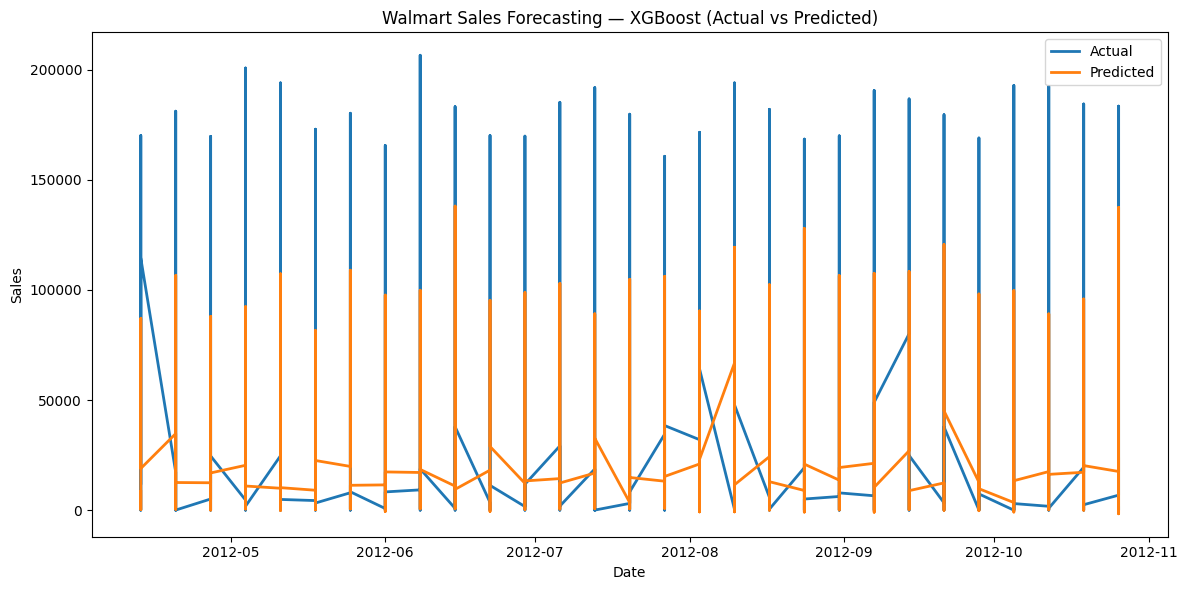


Next 14-Day Forecast (head):
        Date  Predicted_Sales
0 2012-10-27     11546.375977
1 2012-10-28     16295.258789
2 2012-10-29     13781.375000
3 2012-10-30     13227.187500
4 2012-10-31     16490.619141


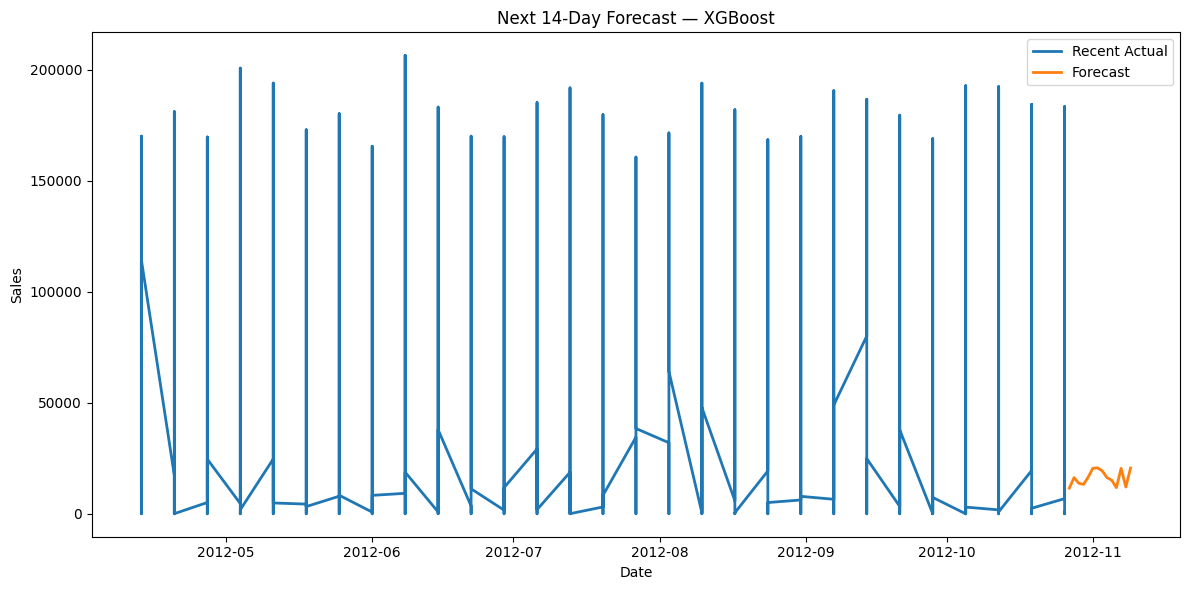


Forecasted Sales for next period (2012-10-27): 11546.38


In [8]:
# Walmart Sales Forecasting with XGBoost, Rolling Averages & STL
# File: forecast_walmart_xgb.py

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.seasonal import STL
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
     eval_metric="rmse" 
)

# fit with eval_metric


# ======================
# 1) Load & sort
# ======================
df = pd.read_csv("clean_data.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

TARGET = "Weekly_Sales"
assert TARGET in df.columns, f"Expected target column '{TARGET}' in CSV."

# ======================
# 2) Feature engineering
# ======================
df["day"] = df["Date"].dt.day
df["month"] = df["Date"].dt.month
df["year"] = df["Date"].dt.year
df["dayofweek"] = df["Date"].dt.dayofweek
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

# Lag features
df["lag_1"]  = df[TARGET].shift(1)
df["lag_7"]  = df[TARGET].shift(7)
df["lag_14"] = df[TARGET].shift(14)
df["lag_28"] = df[TARGET].shift(28)

# Rolling stats
df["roll_mean_7"]  = df[TARGET].shift(1).rolling(7, min_periods=1).mean()
df["roll_mean_28"] = df[TARGET].shift(1).rolling(28, min_periods=1).mean()
df["roll_std_7"]   = df[TARGET].shift(1).rolling(7, min_periods=1).std()
df["roll_std_28"]  = df[TARGET].shift(1).rolling(28, min_periods=1).std()

# STL decomposition (weekly seasonality as example)
period = 7
stl = STL(df[TARGET].fillna(method="ffill").values, period=period, robust=True)
res = stl.fit()
df["stl_trend"]    = pd.Series(res.trend).shift(1)
df["stl_seasonal"] = pd.Series(res.seasonal).shift(1)
df["stl_resid"]    = pd.Series(res.resid).shift(1)

df = df.dropna().reset_index(drop=True)

# ======================
# 3) Train/Test split
# ======================
test_size = int(len(df) * 0.2)
train_df = df.iloc[:-test_size].copy()
test_df  = df.iloc[-test_size:].copy()

FEATURES = [
    "day","month","year","dayofweek","is_weekend",
    "lag_1","lag_7","lag_14","lag_28",
    "roll_mean_7","roll_mean_28","roll_std_7","roll_std_28",
    "stl_trend","stl_seasonal","stl_resid"
]

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET]

# ======================
# 4) Time-aware cross-validation + training
# ======================
tscv = TimeSeriesSplit(n_splits=5)

cv_mses, cv_r2s = [], []
X_train_np, y_train_np = X_train.values, y_train.values

best_model = None
best_val_mse = np.inf

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train_np):
    X_tr, X_val = X_train_np[train_idx], X_train_np[val_idx]
    y_tr, y_val = y_train_np[train_idx], y_train_np[val_idx]

    model = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        tree_method="hist",
        n_jobs=-1
    )
    model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    
    verbose=False
)
    y_val_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_val_pred)
    r2  = r2_score(y_val, y_val_pred)
    cv_mses.append(mse); cv_r2s.append(r2)

    if mse < best_val_mse:
        best_val_mse = mse
        best_model = model

    print(f"[Fold {fold_idx}] MSE: {mse:,.2f} | R2: {r2:.4f}")
    fold_idx += 1

print("\nCV Summary:")
print(f"  Avg MSE: {np.mean(cv_mses):,.2f}  (+/- {np.std(cv_mses):,.2f})")
print(f"  Avg R2 : {np.mean(cv_r2s):.4f}    (+/- {np.std(cv_r2s):.4f})")

# ======================
# 5) Evaluate on test set
# ======================
y_pred_test = best_model.predict(X_test.values)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2  = r2_score(y_test, y_pred_test)

print("\nHeld-out Test Performance:")
print(f"  Test MSE: {test_mse:,.2f}")
print(f"  Test RMSE: {np.sqrt(test_mse):,.2f}")
print(f"  Test R2 : {test_r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(test_df["Date"], y_test.values, label="Actual", linewidth=2)
plt.plot(test_df["Date"], y_pred_test, label="Predicted", linewidth=2)
plt.title("Walmart Sales Forecasting — XGBoost (Actual vs Predicted)")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout()
plt.show()

# ======================
# 6) Multi-step recursive forecast
# ======================
def make_next_feature_row(full_df, next_date):
    row = {}
    row["day"] = next_date.day
    row["month"] = next_date.month
    row["year"] = next_date.year
    row["dayofweek"] = next_date.dayofweek
    row["is_weekend"] = int(next_date.dayofweek >= 5)

    row["lag_1"]  = full_df[TARGET].iloc[-1]
    row["lag_7"]  = full_df[TARGET].iloc[-7]  if len(full_df) >= 7 else row["lag_1"]
    row["lag_14"] = full_df[TARGET].iloc[-14] if len(full_df) >= 14 else row["lag_7"]
    row["lag_28"] = full_df[TARGET].iloc[-28] if len(full_df) >= 28 else row["lag_14"]

    row["roll_mean_7"]  = full_df[TARGET].rolling(7, min_periods=1).mean().iloc[-1]
    row["roll_mean_28"] = full_df[TARGET].rolling(28, min_periods=1).mean().iloc[-1]
    row["roll_std_7"]   = full_df[TARGET].rolling(7, min_periods=1).std().iloc[-1]
    row["roll_std_28"]  = full_df[TARGET].rolling(28, min_periods=1).std().iloc[-1]

    # Trend proxy via moving average
    trend_proxy = full_df[TARGET].rolling(period, min_periods=1).mean().iloc[-1]
    seasonal_proxy = full_df[TARGET].iloc[-1] - trend_proxy
    resid_proxy = 0.0

    row["stl_trend"] = trend_proxy
    row["stl_seasonal"] = seasonal_proxy
    row["stl_resid"] = resid_proxy

    return pd.DataFrame([row])

# Forecast horizon
H = 14
history = df[["Date", TARGET]].copy()
future_dates = pd.date_range(df["Date"].iloc[-1] + pd.Timedelta(days=1), periods=H, freq="D")

future_predictions = []
for d in future_dates:
    feat_row = make_next_feature_row(history.copy(), d)
    feat_row = feat_row[FEATURES]
    pred = float(best_model.predict(feat_row.values)[0])
    future_predictions.append(pred)
    history = pd.concat([history, pd.DataFrame({"Date":[d], TARGET:[pred]})], ignore_index=True)

future_df = pd.DataFrame({"Date": future_dates, "Predicted_Sales": future_predictions})
print("\nNext 14-Day Forecast (head):")
print(future_df.head())

plt.figure(figsize=(12,6))
plt.plot(df["Date"].iloc[-max(60, test_size):], df[TARGET].iloc[-max(60, test_size):], label="Recent Actual", linewidth=2)
plt.plot(future_df["Date"], future_df["Predicted_Sales"], label="Forecast", linewidth=2)
plt.title(f"Next {H}-Day Forecast — XGBoost")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout()
plt.show()

print(f"\nForecasted Sales for next period ({future_dates[0].date()}): {future_predictions[0]:.2f}")
